In [1]:
import pandas as pd
import numpy as np
import tqdm # For getting progress information while the cell is running
# from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import _pickle as pickle
import dtale
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 70)

with open("stock_pickle_full.pickle", 'rb') as fp:
    stocks_df = pickle.load(fp)

In [3]:
def setting_index(df):
    """
    Returns a sorted datetime index
    """
    df['Quarter end'] = pd.to_datetime(df['Quarter end'])
    df.set_index("Quarter end", inplace=True)
    return df.sort_index(ascending=True)
  
def class_creation(df, thres=3):
    """
    Creates classes of:
    - buy(1)
    - hold(2)
    - sell(0)
    
    Threshold can be changed to fit whatever price percentage change is desired
    """
    if df['Price high'] >= thres and df['Price low'] >= thres:
        # Buys
        return 1
    
    elif df['Price high'] <= -thres and df['Price low'] <= -thres:
        # Sells
        return 0
    
    else:
        # Holds
        return 2

In [4]:
"""
# Setting the index as the Date
for i in tqdm(stocks_df.keys()):
    stocks_df[i] = setting_index(stocks_df[i])
    
# Replacing all "None" values with NaN
for i in tqdm(stocks_df.keys()):
    stocks_df[i].replace("None", 0, inplace=True)
    
# Creating a new dictionary that contains the numerical values, then converting all values to numeric values
num_df = {}
for i in tqdm(stocks_df.keys()):
    num_df[i] = stocks_df[i].apply(pd.to_numeric)
    
# Replacing values with percent difference or change
pcnt_df = {}
for i in tqdm(num_df.keys()):
    pcnt_df[i] = num_df[i].pct_change(periods=1).apply(lambda x: x*100)
    
# Replacing infinite values with NaN
for i in tqdm(pcnt_df.keys()):
    pcnt_df[i] = pcnt_df[i].replace([np.inf, -np.inf], np.nan)
    
# Creating a new DataFrame that contains the class 'Decision' determining if a quarterly reports improvement is a buy, hold, or sell.
new_df = {}
for i in tqdm(pcnt_df.keys()):
    # Assigning the new DF
    new_df[i] = pcnt_df[i]
    
    # Creating the new column with the classes, shifted by -1 in order to know if the prices will increase/decrease in the next quarter.
    new_df[i]['Decision'] = new_df[i].apply(class_creation, axis=1).shift(-1)
    
# Excluding the first and last rows
for i in tqdm(new_df.keys()):
    new_df[i] = new_df[i][1:-1]
    
# Combining all stock DFs into one
big_df = pd.DataFrame()
for i in tqdm(pcnt_df.keys()):
    big_df = big_df.append(new_df[i], sort=False)
    
# Filling the NaNs with 0
big_df.fillna(0, inplace=True)

# Resetting the index because we no longer need the dates
big_df.reset_index(drop=True, inplace=True)

# Dropping the price related columns to prevent data leakage
big_df.drop(['Price', 'Price high', 'Price low'], 1, inplace=True)

# Exporting the final DataFrame
with open("main_df.pkl", 'wb') as fp:
    pickle.dump(big_df, fp)
    
"""

'\n# Setting the index as the Date\nfor i in tqdm(stocks_df.keys()):\n    stocks_df[i] = setting_index(stocks_df[i])\n    \n# Replacing all "None" values with NaN\nfor i in tqdm(stocks_df.keys()):\n    stocks_df[i].replace("None", 0, inplace=True)\n    \n# Creating a new dictionary that contains the numerical values, then converting all values to numeric values\nnum_df = {}\nfor i in tqdm(stocks_df.keys()):\n    num_df[i] = stocks_df[i].apply(pd.to_numeric)\n    \n# Replacing values with percent difference or change\npcnt_df = {}\nfor i in tqdm(num_df.keys()):\n    pcnt_df[i] = num_df[i].pct_change(periods=1).apply(lambda x: x*100)\n    \n# Replacing infinite values with NaN\nfor i in tqdm(pcnt_df.keys()):\n    pcnt_df[i] = pcnt_df[i].replace([np.inf, -np.inf], np.nan)\n    \n# Creating a new DataFrame that contains the class \'Decision\' determining if a quarterly reports improvement is a buy, hold, or sell.\nnew_df = {}\nfor i in tqdm(pcnt_df.keys()):\n    # Assigning the new DF\n   

Examining the Data

In [25]:
with open("main_df.pkl", 'rb') as fp:
    final_df = pickle.load(fp)

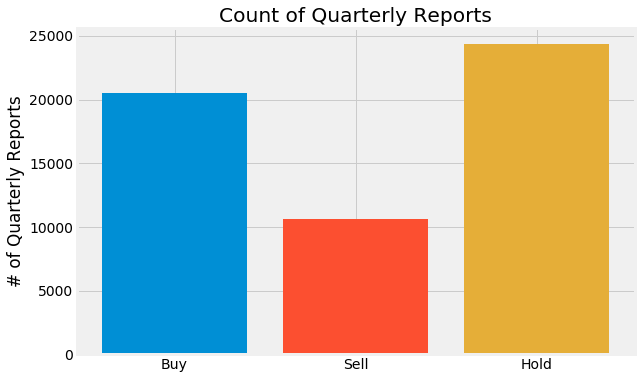

In [6]:
# Seperating each class into respective DataFrames
buy_df = final_df[final_df['Decision']==1].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
hold_df = final_df[final_df['Decision']==2].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
sell_df = final_df[final_df['Decision']==0].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)

# Visualizing in matplotlib
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# Plotting the count of each DataFrame of each class
plt.bar("Buy", buy_df.shape[0])
plt.bar("Sell", sell_df.shape[0])
plt.bar("Hold", hold_df.shape[0])

plt.ylabel('# of Quarterly Reports')
plt.title('Count of Quarterly Reports')
plt.show()

Feature Engineering and Selection

In [8]:
# Setting the correspoinding variables for the classifier
X = final_df.drop(['Decision'], 1)
y = final_df.Decision

# maximum number of features we need to select
num_feats = 15
feature_name = list(X.columns)

# how many features to choose from before selection
print(str(len(feature_name)), 'features to choose from')

37 features to choose from


1. Pearson Correlation

In [8]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

15 selected features


In [9]:
cor_feature

['P/B ratio',
 'Current ratio',
 'Shares',
 'EPS diluted',
 'EPS basic',
 'Split factor',
 'ROA',
 'Goodwill & intangibles',
 'P/E ratio',
 'Shares split adjusted',
 'Cumulative dividends per share',
 'Earnings available for common stockholders',
 'Long-term debt',
 'Assets',
 'Dividend payout ratio']

2. Chi-Square Features

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Normalizing? ( - mean / std?)
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:, chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

15 selected features


In [11]:
chi_feature

['Shares',
 'Current Assets',
 'Current Liabilities',
 'Preferred equity',
 'Goodwill & intangibles',
 'Long-term debt',
 'Revenue',
 'Dividend per share',
 'Cash at end of period',
 'P/B ratio',
 'P/E ratio',
 'Dividend payout ratio',
 'Long-term debt to equity ratio',
 'Net margin',
 'Current ratio']

3. Recursive Feature Elimination

In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 37 features.
Fitting estimator with 27 features.
Fitting estimator with 17 features.


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=15, step=10, verbose=5)

In [13]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

15 selected features


In [14]:
rfe_feature

['Shares',
 'Shares split adjusted',
 'Split factor',
 'Assets',
 'Current Liabilities',
 'Non-controlling interest',
 'Long-term debt',
 'Earnings',
 'Dividend per share',
 'ROA',
 'P/B ratio',
 'Cumulative dividends per share',
 'Dividend payout ratio',
 'Equity to assets ratio',
 'Net margin']

4. SelectFromModel Logistic Regression

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l2',
                                             random_state=None, solver='lbfgs',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=15, norm_order=1, prefit=False, threshold=None)

In [16]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

12 selected features


In [17]:
embeded_lr_feature

['Shares',
 'Split factor',
 'Assets',
 'Current Liabilities',
 'Non-controlling interest',
 'Long-term debt',
 'Dividend per share',
 'ROA',
 'P/B ratio',
 'Cumulative dividends per share',
 'Dividend payout ratio',
 'Equity to assets ratio']

5. Tree_based: SelectFromModel

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [19]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [20]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

15 selected features


In [21]:
embeded_rf_feature

['Shares',
 'Shares split adjusted',
 'Assets',
 'Shareholders equity',
 'Revenue',
 'Cash from operating activities',
 'Cash from investing activities',
 'Cash from financing activities',
 'Cash change during period',
 'Cash at end of period',
 'Capital expenditures',
 'Book value of equity per share',
 'P/B ratio',
 'P/E ratio',
 'Free cash flow per share']

In [22]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

In [23]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                   reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.2,
                                         importance_type='split',
                                         learning_rate=0.05, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         n_jobs=-1, num_leaves=32,
                                         objective=None, random_state=None,
                                         reg_alpha=3, reg_lambda=1, silent=True,
                                         subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_freq=0),
                max_features=15, norm_order=1, prefit=False, 

In [24]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

15 selected features


In [25]:
embeded_lgb_feature

['Shares',
 'Shares split adjusted',
 'Assets',
 'Shareholders equity',
 'Revenue',
 'Cash from operating activities',
 'Cash change during period',
 'Cash at end of period',
 'Capital expenditures',
 'ROE',
 'Book value of equity per share',
 'P/B ratio',
 'P/E ratio',
 'Cumulative dividends per share',
 'Equity to assets ratio']

Results

In [26]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature': feature_name,
                                    'Pearson': cor_support,
                                    'Chi-2': chi_support,
                                    'RFE': rfe_support,
                                    'Logistics': embeded_lr_support,
                                    'Random Forest': embeded_rf_support,
                                    'LightGBM': embeded_lgb_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display top features
feature_selection_df = feature_selection_df.sort_values(['Total', 'Feature'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,Shares,True,True,True,True,True,True,6
2,P/B ratio,True,True,True,True,True,True,6
3,Assets,True,False,True,True,True,True,5
4,Shares split adjusted,True,False,True,False,True,True,4
5,P/E ratio,True,True,False,False,True,True,4
6,Long-term debt,True,True,True,True,False,False,4
7,Dividend payout ratio,True,True,True,True,False,False,4
8,Cumulative dividends per share,True,False,True,True,False,True,4
9,Split factor,True,False,True,True,False,False,3
10,Revenue,False,True,False,False,True,True,3


In [46]:
final_feature = [
    'Shares',
    'P/B ratio',
    'Assets',
    'P/E ratio',
    'Long-term debt',
    'Dividend payout ratio',
    'Cumulative dividends per share',
    'Revenue',
    'ROA',
    'Equity to assets ratio',
    'Dividend per share',
    'Current Liabilities',
    'Shareholders equity',
    'Net margin']

In [47]:
print(final_feature)

['Shares', 'P/B ratio', 'Assets', 'P/E ratio', 'Long-term debt', 'Dividend payout ratio', 'Cumulative dividends per share', 'Revenue', 'ROA', 'Equity to assets ratio', 'Dividend per share', 'Current Liabilities', 'Shareholders equity', 'Net margin']


In [28]:
final_feature_df = X[final_feature] 

In [20]:
# Using the dtale dtale.show() function to build a 'tabular' excel-like 
d1 = dtale.show(final_feature_df)

http://LAPTOP-DL3DBF8J:40000/dtale/main/1
It looks like this data may have already been loaded to D-Tale based on shape and column names. Here is URL of the data that seems to match it:

None

If you still want to load this data please use the following command:

dtale.show(df, ignore_duplicate=True)
Executing shutdown due to inactivity...


2020-04-05 17:14:24,932 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2020-04-05 17:14:37,056 - INFO     - Executing shutdown...


In [50]:
polished_list = final_feature
polished_list.append('Decision')

In [51]:
print(polished_list)

['Shares', 'P/B ratio', 'Assets', 'P/E ratio', 'Long-term debt', 'Dividend payout ratio', 'Cumulative dividends per share', 'Revenue', 'ROA', 'Equity to assets ratio', 'Dividend per share', 'Current Liabilities', 'Shareholders equity', 'Net margin', 'Decision']


In [54]:
"""
the final_df referenced here comes from all the way back to input:
with open("main_df.pkl", 'rb') as fp:
    final_df = pickle.load(fp)
"""
polished_df = final_df[polished_list]

In [55]:
d0 = dtale.show(polished_df)

http://LAPTOP-DL3DBF8J:40000/dtale/main/2
It looks like this data may have already been loaded to D-Tale based on shape and column names. Here is URL of the data that seems to match it:

None

If you still want to load this data please use the following command:

dtale.show(df, ignore_duplicate=True)


In [57]:
d_load = dtale.show(final_df)

http://LAPTOP-DL3DBF8J:40000/dtale/main/3
It looks like this data may have already been loaded to D-Tale based on shape and column names. Here is URL of the data that seems to match it:

None

If you still want to load this data please use the following command:

dtale.show(df, ignore_duplicate=True)


In [ ]:
with open("stock_pickle_full.pickle", 'rb') as fp:
    stocks_df = pickle.load(fp)

In [58]:
with open("polished_df.pkl", "wb") as fp:
    pickle.dump(polished_df, fp)

In [59]:
with open("polished_df.pkl", "rb") as fp:
    pickle.load(fp)

In [60]:
polished_df.head()

,Shares,P/B ratio,Assets,P/E ratio,Long-term debt,Dividend payout ratio,Cumulative dividends per share,Revenue,ROA,Equity to assets ratio,Dividend per share,Current Liabilities,Shareholders equity,Net margin,Decision
0,0.060170,0.000000,3.011116,0.000000,0.0,0.0,0.0,10.641140,0.0,0.459442,0.0,5.757136,3.477486,0.000000,0.0
1,0.164196,-40.465919,6.911624,0.000000,0.0,0.0,0.0,7.444668,0.0,-1.230090,0.0,14.821592,5.601034,0.000000,0.0
2,0.739888,-31.739130,7.640220,0.000000,0.0,0.0,0.0,26.292135,0.0,-0.223535,0.0,9.880478,7.405141,0.000000,2.0
3,0.088384,-2.335456,9.293769,0.000000,0.0,0.0,0.0,-15.747331,0.0,-3.696591,0.0,11.312545,5.242165,0.000000,0.0
4,0.066338,-28.260870,-1.390096,-25.917859,0.0,0.0,0.0,-16.156283,0.0,2.775008,0.0,0.912052,1.353546,-8.163265,2.0
